_____________

# Land Cover Classification for use in the CAPRA Model 

## Image Evaluation and Visualization, Image Data Exploration (GEE Python API)

_______________

### Learning Objectives

In this lesson you will learn how to work with Landsat data in Python. You will learn the concepts of spatial, spectral, temporal and radiometric resolution.

### About Landsat Data

At over 40 years, the Landsat series of satellites provides the longest temporal record of moderate resolution multispectral data of the Earth’s surface on a global basis. The Landsat record has remained remarkably unbroken, proving a unique resource to assist a broad range of specialists in managing the world’s food, water, forests, and other natural resources for a growing world population. It is a record unmatched in quality, detail, coverage, and value. Source: [USGS](https://www.usgs.gov/land-resources/nli/landsat)

Landsat data are spectral and collected using a platform mounted on a satellite in space that orbits the earth. The spectral bands and associated spatial resolution of the first 9 bands in the Landsat 8 sensor are listed below.

<img src="./imgs/L8_bands.png" />


Strips of collected data are packaged into overlapping "scenes" covering approximately 170km x 183km using a standardized reference grid. Each scene is currently imaged every 16 days by Landsat 8. For regional scale application you might have to combine multiple satellite images to fully cover your spatial extent and fill in missing data caused by clouds, etc. Google Earth Engine (GEE) is particularly well suited to these tasks.

When working with landsat, it is important to understand both the metadata and the file naming convention. The metadata tell you how the data were processed, where the data are from and how they are structured.

The file names, tell you what sensor collected the data, the date the data were collected, and more. [More about the Landsat file naming convention.](https://www.usgs.gov/faqs/what-naming-convention-landsat-collections-level-1-scenes?qt-news_science_products=0#qt-news_science_products)

## Landsat data in GEE

We're going to work with a Landsat 8 (L8) image collection which has been processed to surface reflectance values (i.e. the processing has attempted to remove the atmospheric effects). The **Image ID** value is *LANDSAT/LC08/C01/T1_SR*. 

This dataset is the atmospherically corrected surface reflectance from the Landsat 8 OLI/TIRS sensors. These images contain 5 visible and near-infrared (VNIR) bands and 2 short-wave infrared (SWIR) bands processed to orthorectified surface reflectance, and two thermal infrared (TIR) bands processed to orthorectified brightness temperature

These data have been atmospherically corrected using LaSRC and includes a cloud, shadow, water and snow mask produced using CFMASK, as well as a per-pixel saturation mask.

Now that you understand the L8 collection spectral bands and naming convention, you will bring the data into Python. To begin, load the libraries.

In [3]:
# import pretty print package - allows the printing pf Pyhton data structures
#in a form which can be used as input to the interpreter
import pprint
# import Earth Engine (ee) Python API package
import ee 
# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize() 

## Image Collections

A stack or time series of images are called Image Collections. Each data source available on GEE has it’s own Image Collection and ID (for example, the [Landsat 8 SR collection](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR)). You can also create image collections from individual images or merge existing collections. More information on Image Collections can be found here in the [GEE Developer’s Guide](https://developers.google.com/earth-engine/ic_creating).

In [4]:
# load the image collection
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

Let's count how many images are in this collection.

In [8]:
# Count the images in the collection.
print(l8sr.size().getInfo())

844414


We only need L8 data for a specific location and time. Hence we will load the boundary of our area of interest to apply a spatial filter to the Image Collection.

## Load Vector Boundary

We’ll work on filtering the ImageCollection to the boundary of the Dominican Republic. The easiest way to filter for an irregular location without having to identify the paths and rows of the satellite image tiles is to use a vector polygon.

There are different ways to obtain vector data in GEE Python API:

- Import an existing Google Fusion Table, or create your own fusion table from a KML in WGS84. Each fusion table has a unique Id (File > About this table) that can be used to load it into GEE.
- Use an existing vector dataset in GEE. (Browse the vector dataset catalog here)[https://developers.google.com/earth-engine/vector_datasets].
- Manually draw points, lines, and polygons using the geometry tools in the code editor. We will use Google Earth to digitize the training points for the Classify Imagery Module tutorial.

Here, we will use an existing vector asset, the <i>Large Scale International Boundary Polygons, Detailed</i>

In order to load a vector file from your Assets into your workspace, we need to use the “filepath” and cast it to a ee.FeatureCollection data type. Read more here under [“Managing Assets” in the Developer’s Guide](https://developers.google.com/earth-engine/asset_manager#importing-assets-to-your-script).

In [5]:
# Load a polygon boundary (here, a public vector dataset already in GEE)
CBD = ee.FeatureCollection("USDOS/LSIB/2013")
boundary = CBD.filterMetadata('name', 'equals', 'DOMINICAN REPUBLIC')

## Filter an Image Collection

In order to generate images that cover large spatial areas and to fill in image gaps due to clouds, etc, we can load a full ImageCollection but filter the collection to return only the time periods or spatial locations that are of interest. There are shortcut filters for those commonly used (imageCollection.filterDate(), imageCollection.filterBounds()…), but most filter in the ee.Filter() section of the Docs tab can be used. We will also sort by metadata property called 'CLOUD_COVER' and get the first image out of this sorted collection.

To display a single image, we can filter the collection down to a single image, and can request a "thumbnail"  URL for the scene.

In [6]:
image = ee.Image(l8sr
            .filterDate('2019-01-01', '2019-04-30')
            .filterBounds(boundary)
            .sort('CLOUD_COVER')   
            .first()
)
pprint.pprint(image.getInfo())  

{'bands': [{'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 181185.0, 0.0, -30.0, 2355015.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensions': [7671, 7821],
            'id': 'B1'},
           {'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 181185.0, 0.0, -30.0, 2355015.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensions': [7671, 7821],
            'id': 'B2'},
           {'crs': 'EPSG:32619',
            'crs_transform': [30.0, 0.0, 181185.0, 0.0, -30.0, 2355015.0],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensio

Inspect the above metadata and answer the following questions:

#### Questions:<br> (1)	What are the spatial, spectral, radiometric and temporal characteristics of Landsat 8 OLI satellite imagery?<br>  (2)	At what time was the scene obtained?<br>  (3)	How many columns and rows does the scene contain? <br> (4)	What was the sun elevation angle when the scene was obtained? <br> (5) How many bands does the image have and what are their id's?

## Evaluate the distribution of brightness values 

To aid in identifying the information contained in an image, it is often useful to analyze the histogram of each band before carrying out any processing. This is a good way to understand the quality of the original data (whether it is high or low in contrast, normally distributed or multimodal). The histogram shows the frequency of occurrence of each brightness value (BV) within each band. The range of BV’s is provided in the x-axis and the frequency of occurrence of each value is depicted on the y-axis. The peaks in the histogram will correspond to dominant types of land cover in the image of interest.

In GEE, reducers are used to aggregate data over time, space, and other data structures. They belong to the ee.Reducer class and include summary statistics, histograms, and linear regression, among others. Reductions can also occur in space, over bands within an image, or over the attributes of a FeatureCollection. See the Reducer Overview in the Google Developer’s Guide for more information.

A **reducer** makes common calculation such as minimum, maximum, median, first, count, etc. It can be applied to a neighbourhood, region, etc. 

The function *reduceRegion* will be applied over the whole image to obtain the values for the histogram. 

The following parameters can be specified for the function <i>reduceRegion</i>:

+ *reducer*: the *reducer* to apply.
+ *geometry*: region over which the reducer will be applied. By default is the footprint (extent) of the image's first band. <br> 
+ *scale*: scale in meters of the projection. By calling nominalScale() on the ee.Projection returned by projection(), you can determine the native resolution of the image. The native resolution is the nominal pixel scale in meters of the lowest level of the image pyramid. 
+ *crs*: the projection to work in.
+ *crsTransform*: a list of values to apply a transformation of the CRS. Default value: null.
+ *bestEffort*: a flag to indicate that the calculation can be done at larger scale to succeed if too many pixels are involved. Default value: False.
+ *maxPixels*: the maximum number of pixels to process. Default value:10000000.
+ *tileScale*: A scaling factor to aggregate tile size. Default value:1. Using higher values would reduce the memory needed to finish the computation. 

In [8]:
# Filter image collection by selecting on the visible and near infrered bands (bands 2 - 5)
image_hist = ee.Image(l8sr
            .filterDate('2018-01-01', '2019-04-30')
            .filterBounds(boundary)
            .sort('CLOUD_COVER')   
            .select('B[2-5]')
            .first()
)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# compute the histogram 
# set the geometry of the image to use as region in the function reduceRegion
geom = image_hist.geometry()
# set the original scale of the image
scale = image_hist.projection().nominalScale()
# compute the histogram
bfreq = image_hist.reduceRegion(
  reducer = ee.Reducer.frequencyHistogram(),    #.unweighted(),
  geometry = geom,
  scale = scale,
  maxPixels = 162452970 ).getInfo()
#print(bfreq)

# The output of reduceRegion is a dictionary with the format:
# {'bandname': {'key':value}}
    
# We will build series  for x values and y values in order to build the histogram    

# define two dictionaries for frequencies and values respectively
freqs= dict()
vals = dict()

# populate dictionaries
for l in bfreq.keys():
    
    d = bfreq[l]
    #print(d)
    freq = []
    val = []
    for k,v in d.items():
        #print(k,v)
        if not(k == 'null'):
            val.append(int(k))
            freq.append(int(v))
    freqs[l] = freq 
    vals[l] = val
    print('Minimum and maximum value for : %s is %.2f %.2f' % (l, np.min(val), np.max(val) ))
    #print(freqs[l]),np.min(val)

Minimum and maximum value for : B2 is -2000.00 9037.00
Minimum and maximum value for : B3 is -919.00 9652.00
Minimum and maximum value for : B4 is -1192.00 10357.00
Minimum and maximum value for : B5 is -391.00 11019.00


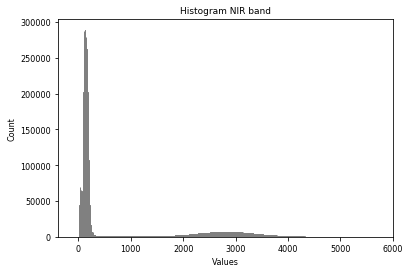

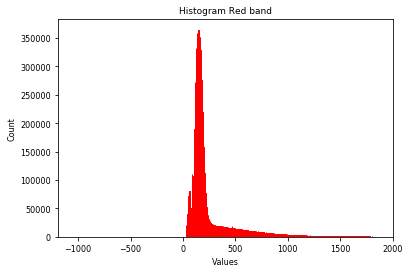

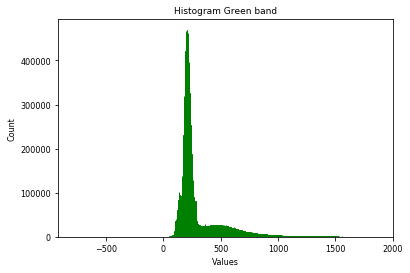

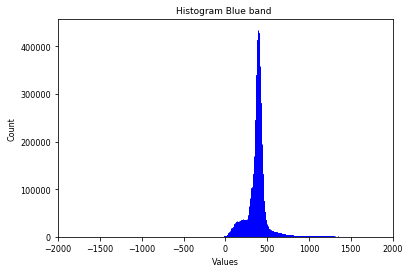

In [19]:
# With the series  freqs and vals, a function will plot histograms for bands B5, B4, B3 and B2
# # function to plot bands red 

def plot_hist(vals, freqs, min = 0, max = 6500, title='Histogram', color = 'red'):
    
    # ind = np.arange(len(vals))  # 
    #plt.bar(vals,freq, color='#7a7476',edgecolor='#7a7476')  
    #plt.ylabel('Count')
    #plt.title('Histogram Band 5')
    f, ax1 = plt.subplots(1,1)
    #ax1.bar( vals['b5'],freqs['b5'],color='gray',edgecolor='gray') #7a7476
    ax1.bar( vals ,freqs,color=color,edgecolor=color) #7a7476
    ax1.set_title(title, fontsize=9)
    ax1.set_xlabel('Values', fontsize=8)
    ax1.set_ylabel('Count', fontsize=8)
    ax1.tick_params( labelsize =8)
    ax1.set_xlim(min,max)
    plt.show()
    
# Call the function. 
# Maximum values in the code below can be modified for visualization purposes.      
plot_hist( vals['B5'],freqs['B5'], -391, 11019,"Histogram NIR band", color = "gray")
plot_hist( vals['B4'],freqs['B4'], -1192, 10357,"Histogram Red band", color = "red")
plot_hist(vals['B3'],freqs['B3'], -919, 9652, "Histogram Green band", color =  "green")
plot_hist( vals['B2'], freqs['B2'], -2000, 9037,"Histogram Blue band ",  "blue")

**Questions:<br>
(6) What is the spectral information represented in band 4?<br>
(7) Looking at the histogram of the near infrared band and looking at the layer, what could each of the two modes represent in the image?**

## Basic Visualization

To visualize an image, the following options, related to the image, can be specified:
- bands: List of three band names to be display in the RGB channels. This is relevant for multiband images.
- palette: Color palette in a list of hexadecimal code strings. Apply to single-band images.
- opacity: The transparency of the layer (0.0 is fully transparent and 1.0 is fully opaque).

Besides, the following visualisation parameters can be specified: 
- min: Value(s) to map to 0. This parameter can be set by examining the distribution of brightness values.
- max: Value(s) to map to 255. This parameter can be set by examining the distribution of brightness values.
- gain: Value(s) by which to multiply each pixel value.
- bias: Value(s) to add to each pixel value.
- gamma: Gamma correction factor(s).

The above parameters are applied per image band. When a multiband image is being displayed, using a single number means that it will be applied to the three bands. Otherwise, a list of three numbers, one for each band can be set.

In GEE playground, an image can be displayed using the function Map.addLayer with parameters listed above. In this tutorial we will use the function getThumbUrl that generates a thumbnail url of the image preview. This preview will be open using Image from the package Ipython.display.

Parameters for the thumbnail can be specified to generate the image. For example, it can be specified bands to display and additional parameters as follows: 
- dimensions: a pair of number specifying the maximum WidthxHeight dimensions of the thumbnail. If only one value is given, it is used as the maximum and the other dimension is computed proportionally. 
- region: region of the image to produce the thumbnail given as GeoJSON or coordinates.
- format: format of the output given as a string ('png' or 'jpg'). 

In the following code we will visualize an image using getThumbUrl.

In [9]:
# import Ipython.display for visualization
from IPython.display import Image  
# the maximun pixel value is 65536 because the image has 16-bit per pixel, but we are 
# making an 8-bit display image, then the pixel values need to be stretched (contrast
# enhancement will be covered in following lesson) )to fit in the range 0 to 255. By examining
# above histograms you will notice that the values fall mostly betwwen 0 and 2000
url  = image_hist.getThumbUrl({'min':0, 'max':2000})
# you could copy and paste this url in a browser to see the image 
print(url)
# display image thumbnails.
Image(url=url)

https://earthengine.googleapis.com/api/thumb?thumbid=1aa6b5e22704b518b29d370082f59c58&token=7be2d6dff6f3cbad00aa669ffd2235db


Single bands will be displayed in a grey scale with an input brightness value of 0 resulting in a very dark (black) display, while a brightness value of 255 is displayed as white. Brightness values between 0 and 255 are displayed as a continuum of grays from black to white. The following image corresponds to band 2 of the Landsat 8 image.

In [10]:
# Filter L8 image for band 2
image_B2 = ee.Image(l8sr
            .filterDate('2018-01-01', '2019-04-30')
            .filterBounds(boundary)
            .sort('CLOUD_COVER')   
            .select('B[2]')
            .first()
)
# the maximun pixel value is 65535 because the image has 16-bit per pixel 
url  = image_B2.getThumbUrl({'min':0, 'max':2000})
# you could copy and paste this url in a browser to see the image 
print(url)
# display image thumbnails.
Image(url=url)

https://earthengine.googleapis.com/api/thumb?thumbid=71959aff7e2d7ae49a10aa5691abdc40&token=832a72ca95cffdb596fef81f40960354


In [11]:
geom_B2 = image_B2.geometry()
scale_B2 = image_B2.projection().nominalScale()
maxReducer = ee.Reducer.max();
theMax = image_B2.reduceRegion(
    reducer = ee.Reducer.max(),
    geometry = geom_B2,
    scale = scale_B2,
    maxPixels = 40613241 ).getInfo()

In [21]:
print(theMax)

{'B2': 9037}


## Color composites

Landsat 8 measures radiance in multiple spectral bands. A common way to visualize images is to set the red band to display in red, the green band to display in green and the blue band to display in blue (trying to match the spectral response of the instrument to the spectral response of the photoreceptors in the human eye). This is called a true-color image. When the display bands don't match human visual perception, the resultant visualization is called a false-color composite. 

Now you will make different visualizations of the above scene.

In [11]:
# Specify the bands to make a RGB composite.
# First, get the band names of the image
names = image.bandNames();
print(names.getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol', 'pixel_qa', 'radsat_qa']


In [12]:
# We may want to select only the band in the visible range, this mean bands blue, green and red (bands: B2,B3,B4)  
# To display a RGB natural color composite, the band order must be set to [B4,B3,B2] 
# gamma corrections factors (one per band), You can use the values obtained above to set your max
Image(url=image.getThumbUrl({'min': 0, 'max': 2000,'bands': 'B4,B3,B2', 'gamma': '0.95, 1.1, 1'}))

In [13]:
# Apply "false color" composite
Image(url=image.getThumbUrl({'min': 0, 'max': 2000,'bands': 'B5,B4,B3', 'gamma': '1, 1, 1'}))